In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Function to set the seed for reproducibility
import random
def set_seed(seed_value=42):
        """Set seed for reproducibility.

    This function ensures consistent results across different runs by setting
    the random seed for NumPy, PyTorch, Python's random module, and the
    environment variable PYTHONHASHSEED.

    Args:
        seed_value (int, optional): The desired seed value. Defaults to 42.
    """
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_autoencoder(config):
        """Trains an autoencoder with the given configuration.

    Args:
        config (dict): A dictionary containing the configuration
                       for the autoencoder, including encoder and
                       decoder layers, activation function,
                       latent dimension, and number of epochs.

    Returns:
        nn.Module: The trained autoencoder model.
    """

    # Create the autoencoder model
    class Autoencoder(nn.Module):
        def __init__(self, encoder_layers, decoder_layers, activation, latent_dim):
            """Initializes the Autoencoder model.

            Args:
                encoder_layers (list): List of layer sizes for the encoder.
                decoder_layers (list): List of layer sizes for the decoder.
                activation (nn.Module): Activation function to use.
                latent_dim (int): Dimensionality of the latent space.
            """
            super(Autoencoder, self).__init__()

            # Encoder
            encoder_modules = []
            input_size = 784
            for layer_size in encoder_layers:
                encoder_modules.extend([nn.Linear(input_size, layer_size), activation()])
                input_size = layer_size
            encoder_modules.append(nn.Linear(input_size, latent_dim))
            self.encoder = nn.Sequential(*encoder_modules)

            # Decoder
            decoder_modules = []
            input_size = latent_dim
            for layer_size in decoder_layers:
                decoder_modules.extend([nn.Linear(input_size, layer_size), activation()])
                input_size = layer_size
            decoder_modules.append(nn.Linear(input_size, 784))
            decoder_modules.append(nn.Sigmoid())  # Output layer with sigmoid for MNIST
            self.decoder = nn.Sequential(*decoder_modules)

        def forward(self, x):
          """Defines the forward pass of the Autoencoder.

            Args:
                x (torch.Tensor): Input tensor.

            Returns:
                tuple: A tuple containing the encoded and decoded tensors.
            """
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

    model = Autoencoder(
        config['encoder_layers'],
        config['decoder_layers'],
        config['activation'],
        config['latent_dim']
    ).to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = config['epochs']
    for epoch in range(num_epochs):
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.view(-1, 784).to(device)
            optimizer.zero_grad()
            encoded, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

        print(f'Model: {config["name"]}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model

In [ ]:
# Load the MNIST dataset
# Define a transformation pipeline to convert images to tensors.
transform = transforms.Compose([transforms.ToTensor()])

# Load the training and testing datasets using the torchvision.datasets.MNIST class.
# Specify the data directory, download option, and the transform to apply.
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for the training and testing datasets.
# DataLoaders handle batching and shuffling of data during training and testing.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.42MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Image Shape :  torch.Size([1, 28, 28])
Image Data
tensor(0.) tensor(1.)
The pixel data ranges between 0 and 1.


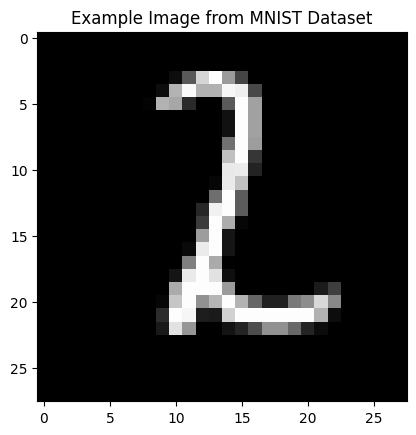

In [ ]:
# Examine the result and real

# Get a batch of training data
images, labels = next(iter(train_loader))

# Select a random image from the batch
random_index = random.randint(0, len(images) - 1)
selected_image = images[random_index]

# Print information about the selected image
print("Image Shape : ", selected_image.shape)
print("Image Data")
print(selected_image.min(), selected_image.max())
print("The pixel data ranges between 0 and 1.")

# Display the image
plt.imshow(selected_image.view(28, 28), cmap="gray")
plt.title("Example Image from MNIST Dataset")
plt.show()

In [ ]:
# Define configurations for different autoencoder models
# Each configuration is a dictionary containing the model's name,
# encoder and decoder layer sizes, activation function,
# latent dimension, and number of training epochs.
configs = [
    {'name': 'Model1', 'encoder_layers': [500, 100], 'decoder_layers': [100, 500], 'activation': nn.ReLU, 'latent_dim': 2, 'epochs': 10},
    {'name': 'Model2', 'encoder_layers': [500, 250, 100], 'decoder_layers': [100, 250, 500], 'activation': nn.ReLU, 'latent_dim': 2, 'epochs': 10},
    {'name': 'Model3', 'encoder_layers': [500, 100], 'decoder_layers': [100, 500], 'activation': nn.Sigmoid, 'latent_dim': 5, 'epochs': 10},
    {'name': 'Model4', 'encoder_layers': [500, 100], 'decoder_layers': [100, 500], 'activation': nn.Tanh, 'latent_dim': 10, 'epochs': 10},
     {'name': 'Model5', 'encoder_layers': [500, 250, 100], 'decoder_layers': [100, 250, 500], 'activation': nn.ReLU, 'latent_dim': 32, 'epochs': 10}, # Latent dim 32
    {'name': 'Model6', 'encoder_layers': [500, 250, 100], 'decoder_layers': [100, 250, 500], 'activation': nn.ReLU, 'latent_dim': 64, 'epochs': 10}, # Latent dim 64
]

In [ ]:
trained_models = {}
for config in configs:
    model = train_autoencoder(config)
    trained_models[config['name']] = model
    # Save the model
    torch.save(model.state_dict(), f"{config['name']}_model.pth")

Model: Model1, Epoch [1/10], Loss: 0.2245
Model: Model1, Epoch [2/10], Loss: 0.1965
Model: Model1, Epoch [3/10], Loss: 0.2056
Model: Model1, Epoch [4/10], Loss: 0.1917
Model: Model1, Epoch [5/10], Loss: 0.1832
Model: Model1, Epoch [6/10], Loss: 0.1791
Model: Model1, Epoch [7/10], Loss: 0.1806
Model: Model1, Epoch [8/10], Loss: 0.1698
Model: Model1, Epoch [9/10], Loss: 0.1821
Model: Model1, Epoch [10/10], Loss: 0.1657
Model: Model2, Epoch [1/10], Loss: 0.2060
Model: Model2, Epoch [2/10], Loss: 0.2028
Model: Model2, Epoch [3/10], Loss: 0.1849
Model: Model2, Epoch [4/10], Loss: 0.1869
Model: Model2, Epoch [5/10], Loss: 0.1798
Model: Model2, Epoch [6/10], Loss: 0.1821
Model: Model2, Epoch [7/10], Loss: 0.1557
Model: Model2, Epoch [8/10], Loss: 0.1812
Model: Model2, Epoch [9/10], Loss: 0.1777
Model: Model2, Epoch [10/10], Loss: 0.1715
Model: Model3, Epoch [1/10], Loss: 0.2445
Model: Model3, Epoch [2/10], Loss: 0.2267
Model: Model3, Epoch [3/10], Loss: 0.2264
Model: Model3, Epoch [4/10], Los

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, test_loader, num_images=10):
        """Visualizes original and reconstructed images from the test set.

    Args:
        model (nn.Module): The trained autoencoder model.
        test_loader (DataLoader): DataLoader for the test set.
        num_images (int, optional): Number of images to visualize. Defaults to 10.
    """

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.view(-1, 784).to(device)
            encoded, outputs = model(inputs)
            break

    # Reshape to images
    inputs = inputs.view(-1, 28, 28)
    outputs = outputs.view(-1, 28, 28)

    # Plot
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(inputs[i].cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstruction
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(outputs[i].cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
import numpy as np

def compare_loss_functions(trained_models, test_loader):
    """Compares the loss functions of trained models on the test set."""

    loss_values = {}
    criterion = nn.BCELoss()

    for model_name, model in trained_models.items():
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, _ = data
                inputs = inputs.view(-1, 784).to(device)
                encoded, outputs = model(inputs)
                loss = criterion(outputs, inputs)
                total_loss += loss.item()

        loss_values[model_name] = total_loss / len(test_loader)

    # Print or plot the loss values
    for model_name, loss_value in loss_values.items():
        print(f"Model: {model_name}, Test Loss: {loss_value:.4f}")

    # You can also plot the loss values for visualization
    plt.bar(loss_values.keys(), loss_values.values())
    plt.ylabel('Test Loss')
    plt.title('Comparison of Test Loss for Different Models')
    plt.show()

Visualizing reconstructions for Model1:


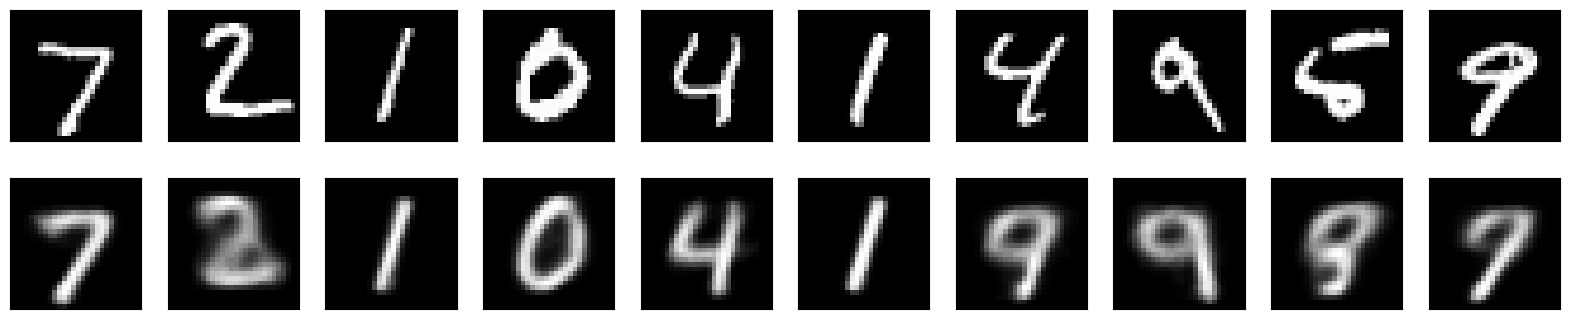

Visualizing reconstructions for Model2:


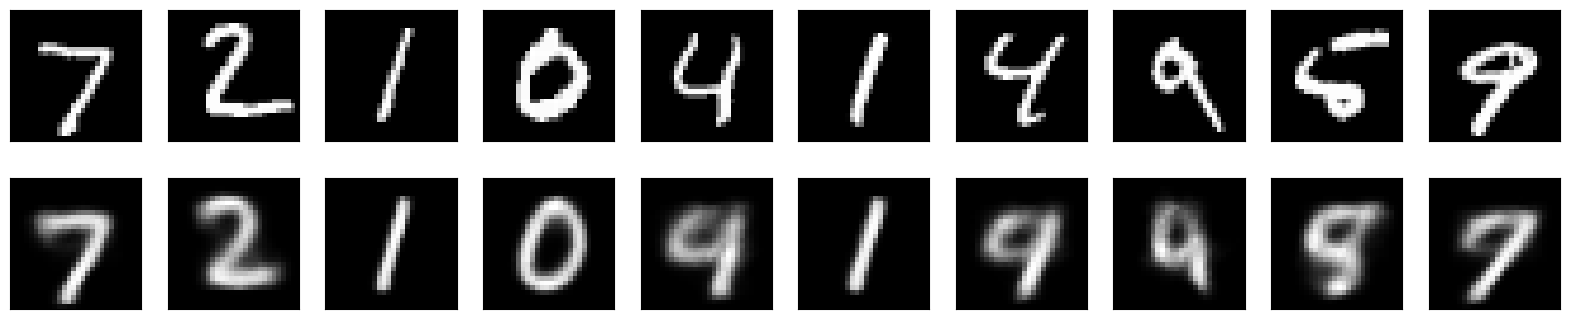

Visualizing reconstructions for Model3:


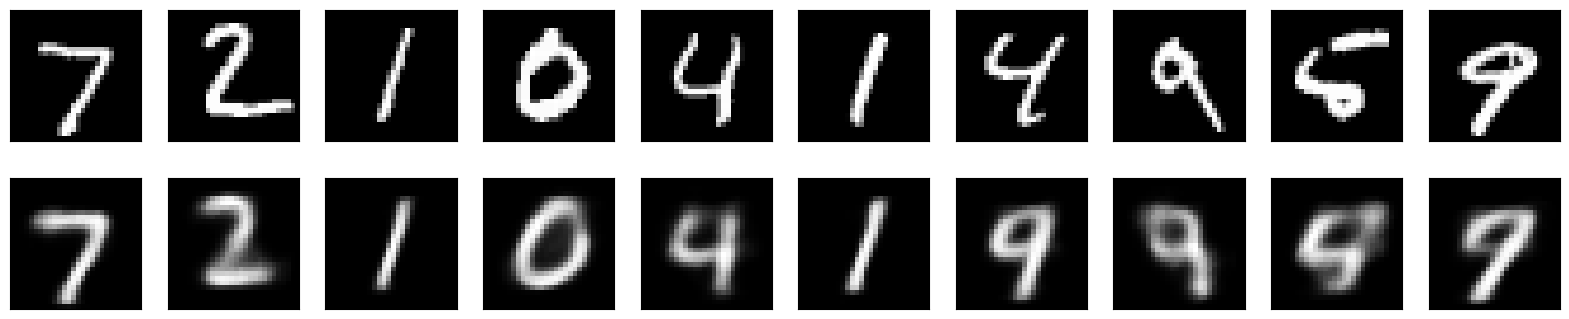

Visualizing reconstructions for Model4:


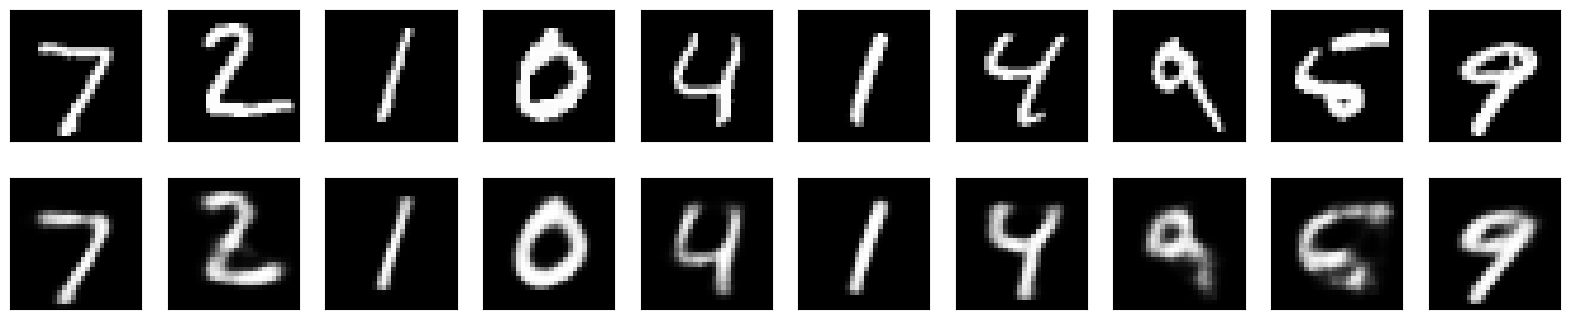

Visualizing reconstructions for Model5:


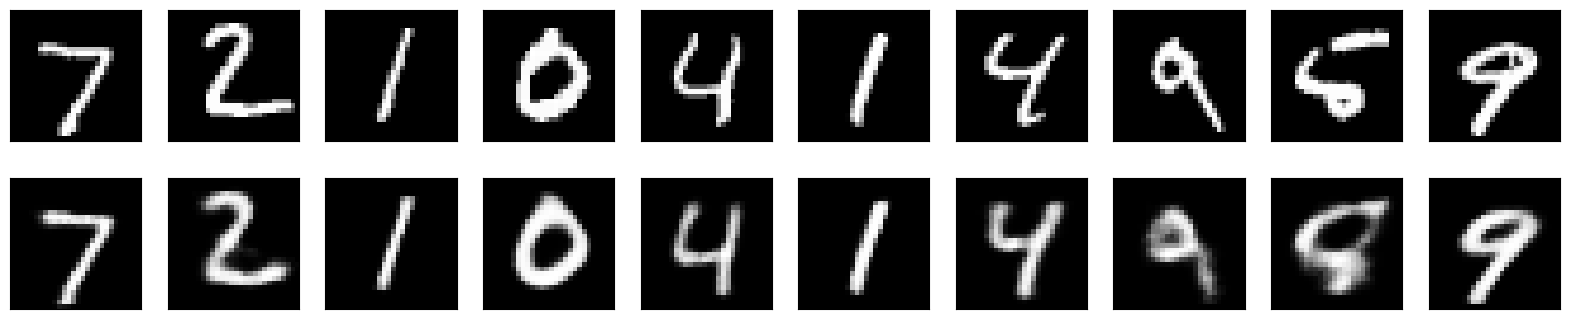

Visualizing reconstructions for Model6:


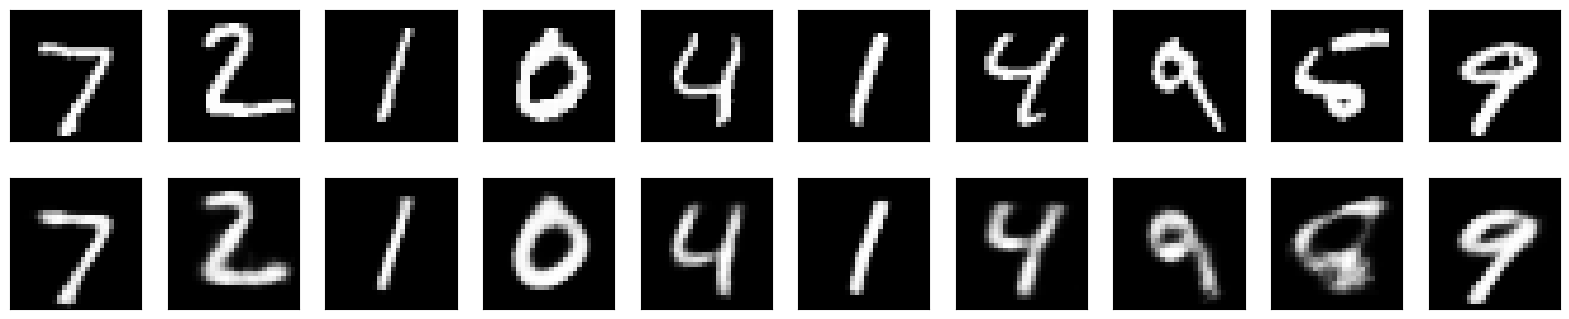

Model: Model1, Test Loss: 0.1794
Model: Model2, Test Loss: 0.1720
Model: Model3, Test Loss: 0.1631
Model: Model4, Test Loss: 0.1126
Model: Model5, Test Loss: 0.1017
Model: Model6, Test Loss: 0.1018


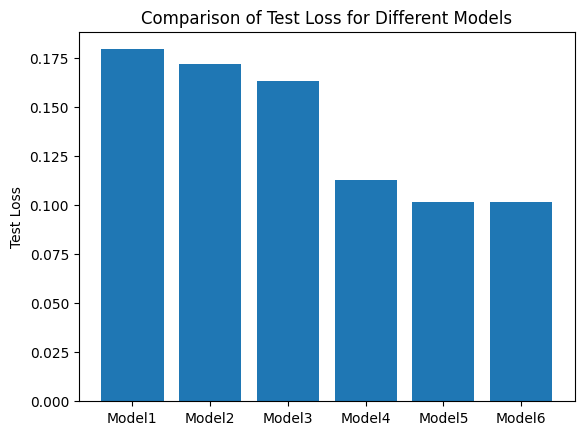

In [ ]:
for model_name, model in trained_models.items():
    print(f"Visualizing reconstructions for {model_name}:")
    visualize_reconstructions(model, test_loader)

compare_loss_functions(trained_models, test_loader)

In [ ]:
import numpy as np

def add_noise(images, noise_type='gaussian', noise_factor=0.5):
    """Adds noise to images.

    Args:
        images (torch.Tensor): The input images.
        noise_type (str, optional): The type of noise to add ('gaussian', 'salt_pepper', 'speckle'). Defaults to 'gaussian'.
        noise_factor (float, optional): The amount of noise to add. Defaults to 0.5.

    Returns:
        torch.Tensor: The noisy images.

    Raises:
        ValueError: If an invalid noise type is provided.
    """
    if noise_type == 'gaussian':
        noisy_images = images + noise_factor * torch.randn(*images.shape)
    elif noise_type == 'salt_pepper':
        # Salt & Pepper noise
        noisy_images = images.clone()
        num_pixels = int(noise_factor * images.numel())
        indices = np.random.choice(images.numel(), size=num_pixels, replace=False)
        noisy_images.view(-1)[indices] = torch.randint(0, 2, size=(num_pixels,)).float()
    elif noise_type == 'speckle':
        # Speckle noise
        noisy_images = images + images * noise_factor * torch.randn(*images.shape)
    else:
        raise ValueError(f"Invalid noise type: {noise_type}")
    # Clip the noisy images to the range [0, 1]
    noisy_images = torch.clamp(noisy_images, 0., 1.)  # Clip to [0, 1]
    return noisy_images

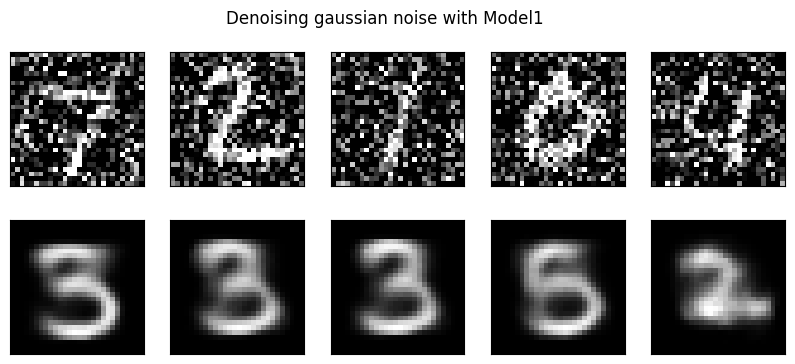

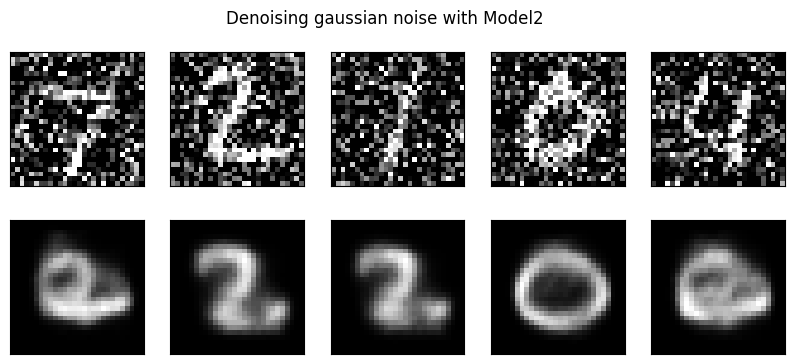

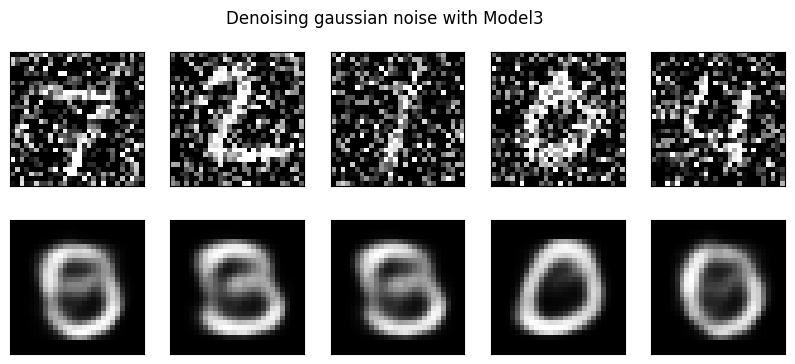

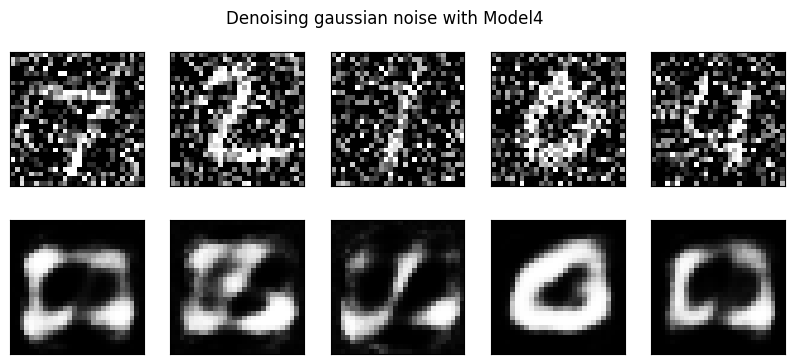

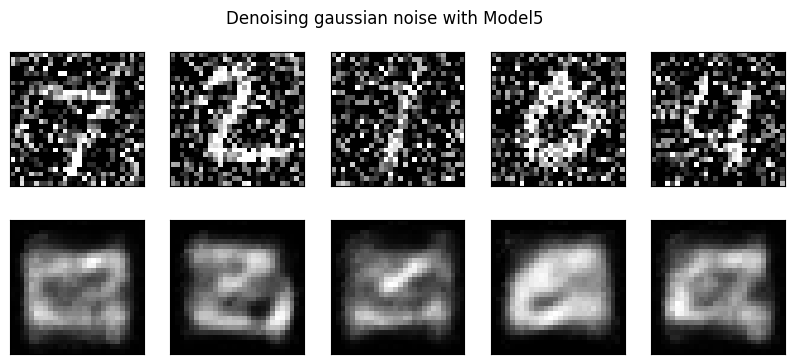

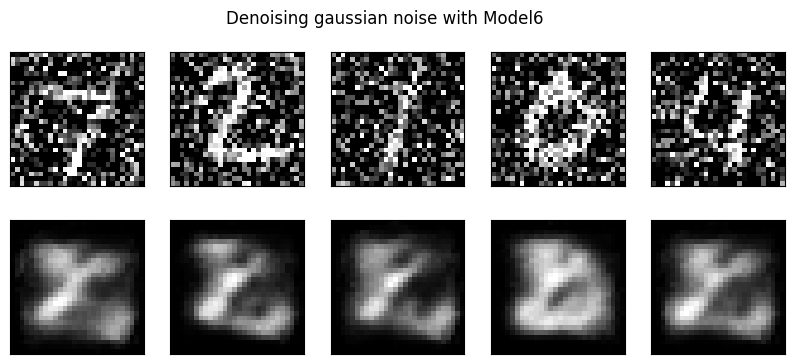

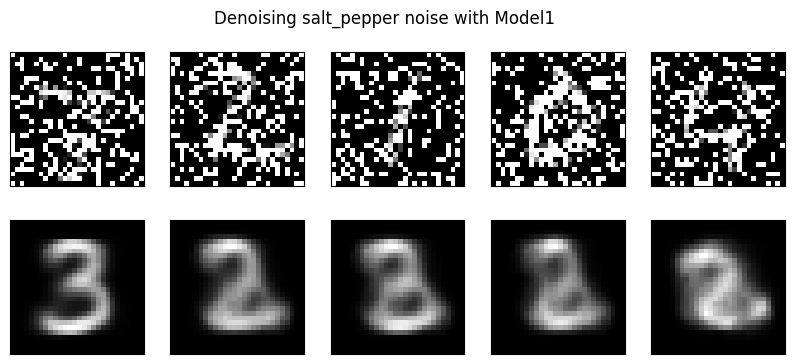

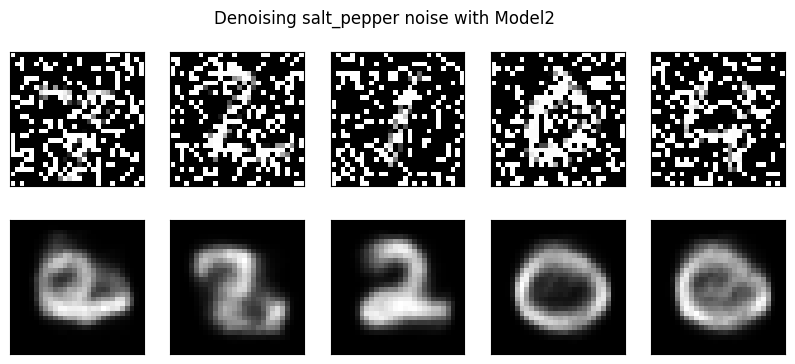

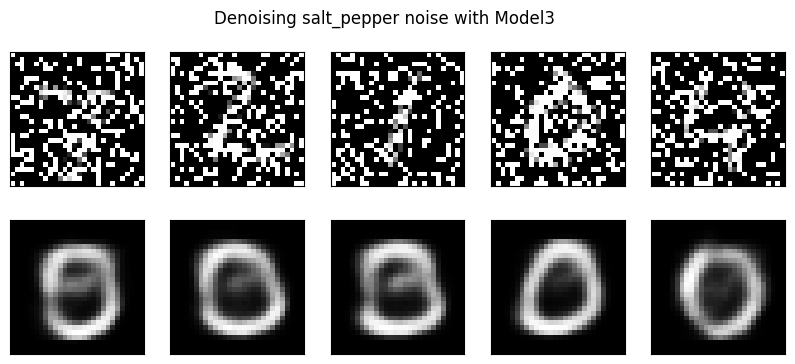

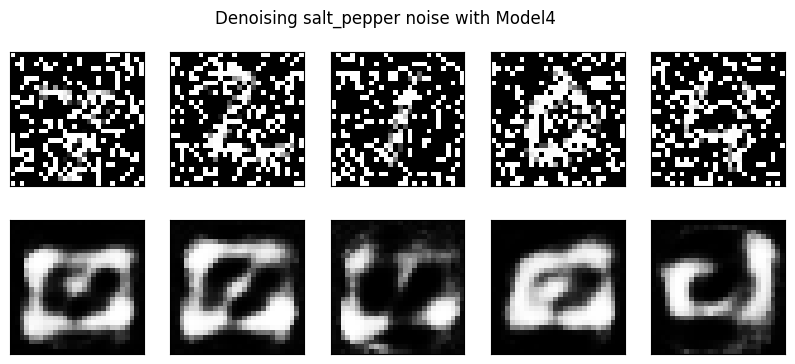

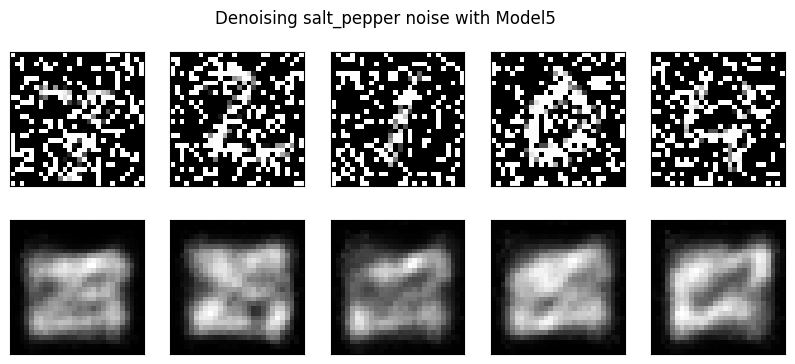

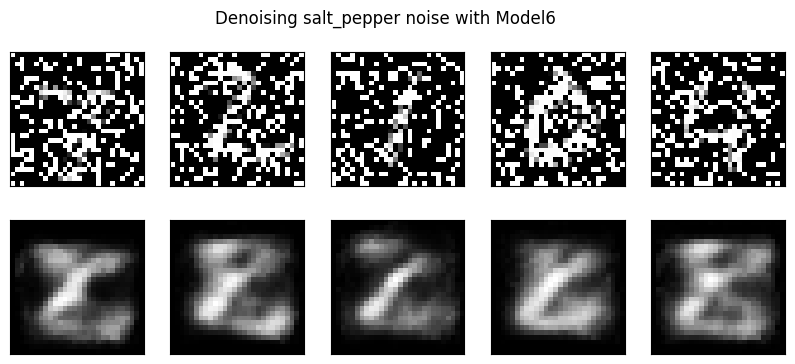

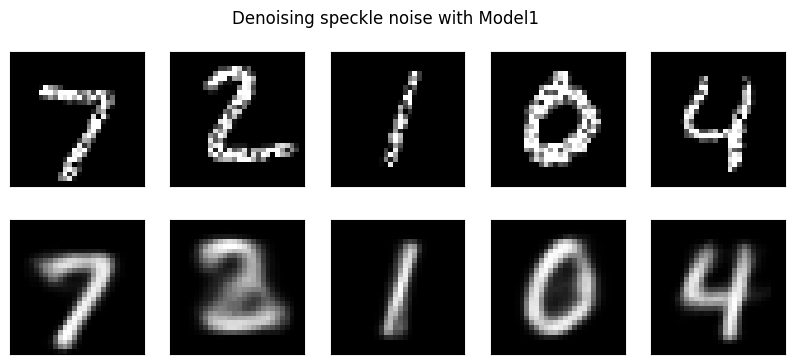

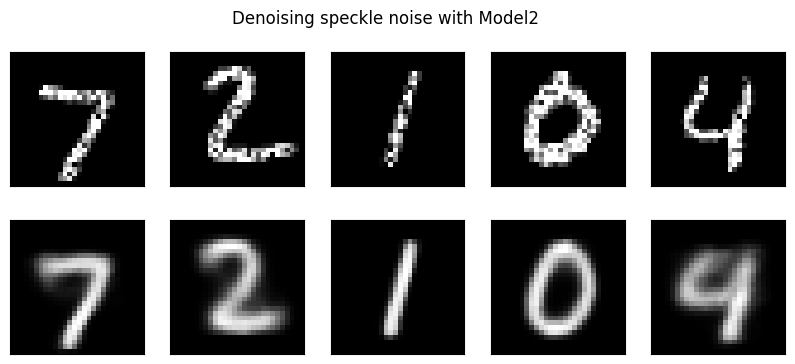

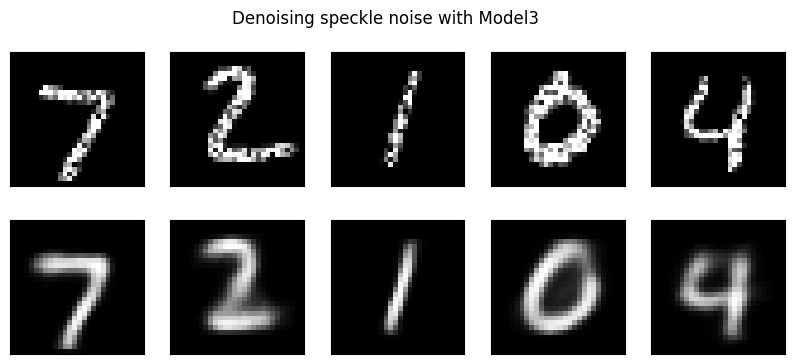

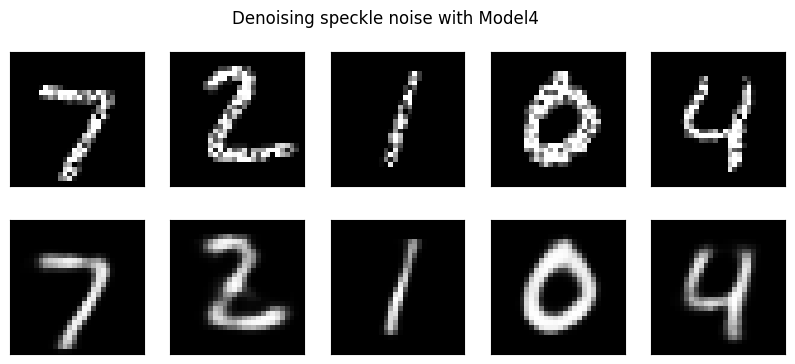

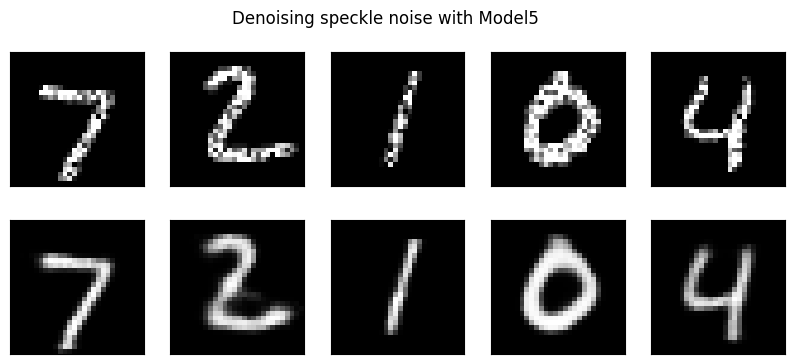

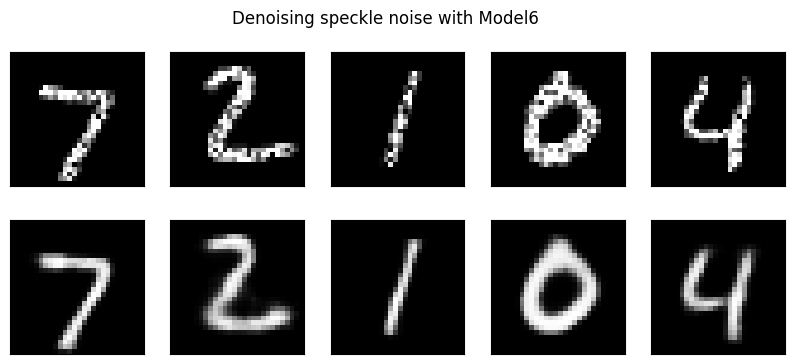

In [ ]:
import matplotlib.pyplot as plt

def denoise_images(model, noisy_images):
     """Denoises images using the trained autoencoder.

    Args:
        model (nn.Module): The trained autoencoder model.
        noisy_images (torch.Tensor): The noisy images to denoise.

    Returns:
        torch.Tensor: The denoised images.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        noisy_images = noisy_images.view(-1, 784).to(device)   # Reshape and move to device
        _, denoised_images = model(noisy_images)  # Get the decoded output
        denoised_images = denoised_images.view(-1, 28, 28)  # Reshape back to image format
    return denoised_images

noise_types = ['gaussian', 'salt_pepper', 'speckle']

for noise_type in noise_types:
    # Get a batch of test images
    images, _ = next(iter(test_loader))

    # Add noise to the images
    noisy_images = add_noise(images, noise_type=noise_type, noise_factor=0.5)

    # Denoise the images using each model and visualize
    for model_name, model in trained_models.items():
        denoised_images = denoise_images(model, noisy_images)

        # Visualize the noisy and denoised images
        plt.figure(figsize=(10, 4))
        for i in range(5):  # Display 5 images for comparison
            # Noisy image
            ax = plt.subplot(2, 5, i + 1)
            # Squeeze the channel dimension before displaying
            plt.imshow(noisy_images[i].squeeze().cpu().numpy(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Denoised image
            ax = plt.subplot(2, 5, i + 1 + 5)
            # Squeeze the channel dimension before displaying
            plt.imshow(denoised_images[i].squeeze().cpu().numpy(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.suptitle(f"Denoising {noise_type} noise with {model_name}")
        plt.show()

In [ ]:
# Create the directory structure
!mkdir -p /content/coco/annotations /content/coco/val2017

# Download annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco/

# Download validation images (val2017)
!wget http://images.cocodataset.org/zips/val2017.zip -P /content/coco/

# Extract the downloaded files
!unzip -q /content/coco/annotations_trainval2017.zip -d /content/coco/annotations/
!unzip -q /content/coco/val2017.zip -d /content/coco/


--2025-01-22 17:19:12--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.131.9, 52.217.168.33, 52.217.123.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.131.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/coco/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  94.3MB/s    in 2.6s    

2025-01-22 17:19:14 (94.3 MB/s) - ‘/content/coco/annotations_trainval2017.zip’ saved [252907541/252907541]

--2025-01-22 17:19:14--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.131.9, 52.217.168.33, 52.217.123.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.131.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Savi

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
Loaded 5000 samples from COCO.
Sample Image Shape: torch.Size([3, 64, 64])
Annotation: [{'segmentation': [[240.86, 211.31, 240.16, 197.19, 236.98, 192.26, 237.34, 187.67, 245.8, 188.02, 243.33, 176.02, 250.39, 186.96, 251.8, 166.85, 255.33, 142.51, 253.21, 190.49, 261.68, 183.08, 258.86, 191.2, 260.98, 206.37, 254.63, 199.66, 252.51, 201.78, 251.8, 212.01]], 'area': 531.8071000000001, 'iscrowd': 0, 'image_id': 139, 'bbox': [236.98, 142.51, 24.7, 69.5], 'category_id': 64, 'id': 26547}, {'segmentation': [[9.66, 167.76, 156.35, 173.04, 153.71, 256.48, 82.56, 262.63, 7.03, 260.87]], 'area': 13244.657700000002, 'iscrowd': 0, 'image_id': 139, 'bbox': [7.03, 167.76, 149.32, 94.87], 'category_id': 72, 'id': 34646}, {'segmentation': [[563.33, 209.19, 637.69, 209.19, 638.56, 287.92, 557.21, 280.04]], 'area': 5833.117949999999, 'iscrowd': 0, 'image_id': 139, 'bbox': [557.21, 209.19, 81.35, 78.73], 'category_id': 72

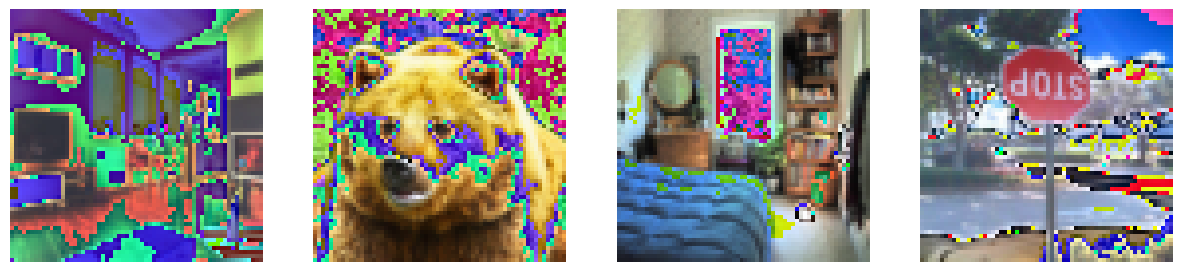

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import os

# Set COCO dataset path
coco_path = "/content/coco"

# Install pycocotools
!pip install pycocotools

# Create a preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),       # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize between -1 and 1
])

# Load COCO dataset (validation set as an example)
coco_dataset = CocoDetection(root=os.path.join(coco_path, 'val2017'),
                             annFile=os.path.join(coco_path, 'annotations/annotations/instances_val2017.json'),
                             transform=transform)


# Display Information
print(f"Loaded {len(coco_dataset)} samples from COCO.")

# Validate Dataset
img, ann = coco_dataset[0]  # Load first image and annotation
print(f"Sample Image Shape: {img.shape}")
print(f"Annotation: {ann}")

# DataLoader
coco_loader = DataLoader(coco_dataset, batch_size=4, shuffle=True)

# Display a Few Images
def show_images(dataset, num_images=4):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, _ = dataset[i]  # Properly index the dataset
        ax[i].imshow(to_pil_image(img))
        ax[i].axis("off")
    plt.show()

show_images(coco_dataset, num_images=4)


In [ ]:
# Update the transformation pipeline
transform_coco = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.Grayscale(),       # Convert to grayscale
    transforms.ToTensor(),       # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale image
])

In [ ]:
#Reload COCO dataset with updated transform
coco_dataset_resized = CocoDetection(root=os.path.join(coco_path, 'val2017'),
                                      annFile=os.path.join(coco_path, 'annotations/annotations/instances_val2017.json'),
                                      transform=transform_coco)

from torch.utils.data.dataloader import default_collate

def custom_collate(batch):
    # Filter out annotations and only return the images
    return default_collate([item[0] for item in batch])

# Apply the custom collate function to your COCO DataLoader
coco_loader_resized = DataLoader(coco_dataset_resized, batch_size=256, shuffle=True, collate_fn=custom_collate)


loading annotations into memory...
Done (t=1.47s)
creating index...
index created!


In [ ]:
class Autoencoder_COCO(nn.Module):
  """Autoencoder model for COCO dataset images."""
    def __init__(self, encoder_layers, decoder_layers, activation, latent_dim):
       """Initializes the Autoencoder_COCO model.

        Args:
            encoder_layers (list): List of layer sizes for the encoder.
            decoder_layers (list): List of layer sizes for the decoder.
            activation (nn.Module): Activation function to use.
            latent_dim (int): Dimensionality of the latent space.
        """
        super(Autoencoder_COCO, self).__init__()

        # Encoder
        encoder_modules = []
        input_size = 784  # Input size for 28x28 grayscale images
        for layer_size in encoder_layers:
            encoder_modules.extend([nn.Linear(input_size, layer_size), activation()])
            input_size = layer_size
        encoder_modules.append(nn.Linear(input_size, latent_dim))
        self.encoder = nn.Sequential(*encoder_modules)

        # Decoder
        decoder_modules = []
        input_size = latent_dim
        for layer_size in decoder_layers:
            decoder_modules.extend([nn.Linear(input_size, layer_size), activation()])
            input_size = layer_size
        decoder_modules.append(nn.Linear(input_size, 784))  # Output size for 28x28 grayscale images
        decoder_modules.append(nn.Sigmoid())  # Output layer with sigmoid
        self.decoder = nn.Sequential(*decoder_modules)

    def forward(self, x):
       """Defines the forward pass of the Autoencoder_COCO.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            tuple: A tuple containing the encoded and decoded tensors.
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:

# Train the autoencoder on the COCO dataset
trained_models_coco = {}  # Dictionary to store trained models
num_epochs = 50  # Number of training epochs

for config in configs:
    # Create an instance of the Autoencoder_COCO model
    model_coco = Autoencoder_COCO(
        config['encoder_layers'],
        config['decoder_layers'],
        config['activation'],
        config['latent_dim']
    ).to(device)

    # Define the loss function (Mean Squared Error) and optimizer (Adam)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_coco.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(num_epochs):
        for data in coco_loader_resized:  # Iterate through batches of COCO data
            inputs = data  # Get the images from the batch (custom collate function returns only images)
            inputs = inputs.view(-1, 1, 28, 28).to(device)  # Reshape and move images to the device
            inputs = inputs.view(-1, 784).to(device)  # Flatten the images for the autoencoder input

            optimizer.zero_grad()  # Reset gradients
            encoded, outputs = model_coco(inputs)  # Forward pass
            loss = criterion(outputs, inputs)  # Calculate the loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters

        # Print the training progress
        print(f'Model: {config["name"]}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Store the trained model in the dictionary
    trained_models_coco[config['name']] = model_coco
    # Save the trained model's state dictionary
    torch.save(model_coco.state_dict(), f"{config['name']}_coco_model.pth")

Model: Model1, Epoch [1/50], Loss: 0.5576
Model: Model1, Epoch [2/50], Loss: 0.4029
Model: Model1, Epoch [3/50], Loss: 0.2527
Model: Model1, Epoch [4/50], Loss: 0.2186
Model: Model1, Epoch [5/50], Loss: 0.2142
Model: Model1, Epoch [6/50], Loss: 0.2223
Model: Model1, Epoch [7/50], Loss: 0.2232
Model: Model1, Epoch [8/50], Loss: 0.2197
Model: Model1, Epoch [9/50], Loss: 0.2093
Model: Model1, Epoch [10/50], Loss: 0.2137
Model: Model1, Epoch [11/50], Loss: 0.2030
Model: Model1, Epoch [12/50], Loss: 0.2122
Model: Model1, Epoch [13/50], Loss: 0.1930
Model: Model1, Epoch [14/50], Loss: 0.2179
Model: Model1, Epoch [15/50], Loss: 0.2019
Model: Model1, Epoch [16/50], Loss: 0.2055
Model: Model1, Epoch [17/50], Loss: 0.2138
Model: Model1, Epoch [18/50], Loss: 0.2056
Model: Model1, Epoch [19/50], Loss: 0.2030
Model: Model1, Epoch [20/50], Loss: 0.1950
Model: Model1, Epoch [21/50], Loss: 0.1969
Model: Model1, Epoch [22/50], Loss: 0.2022
Model: Model1, Epoch [23/50], Loss: 0.1982
Model: Model1, Epoch

Visualizing reconstructions for Model1 (COCO):


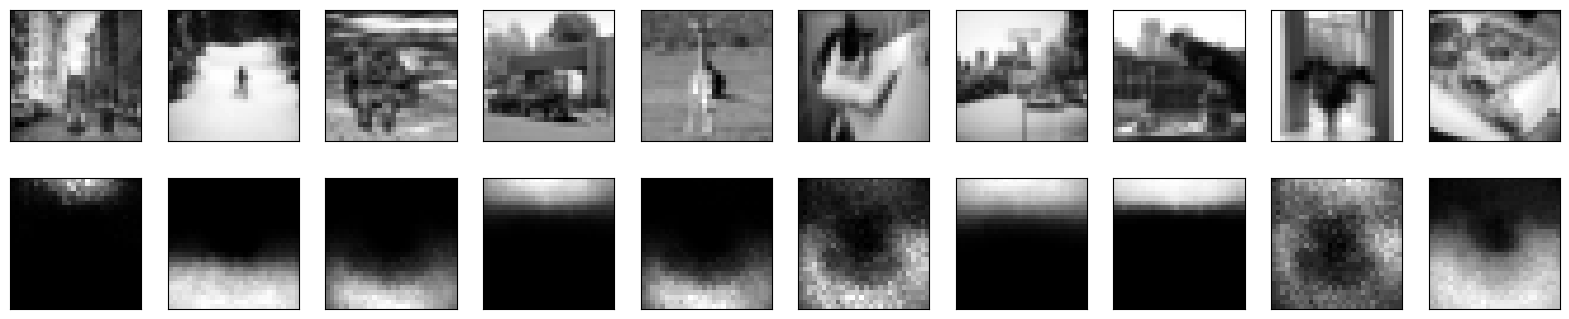

Visualizing reconstructions for Model2 (COCO):


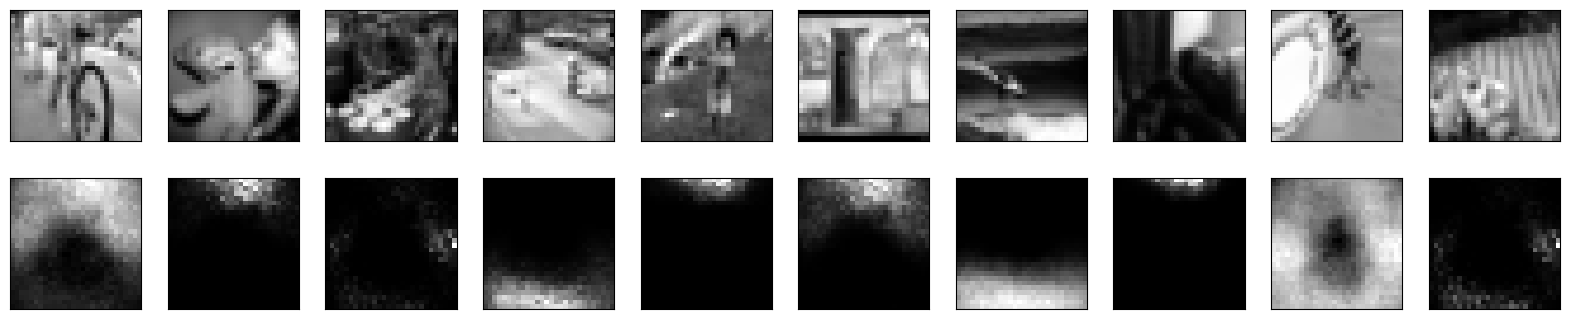

Visualizing reconstructions for Model3 (COCO):


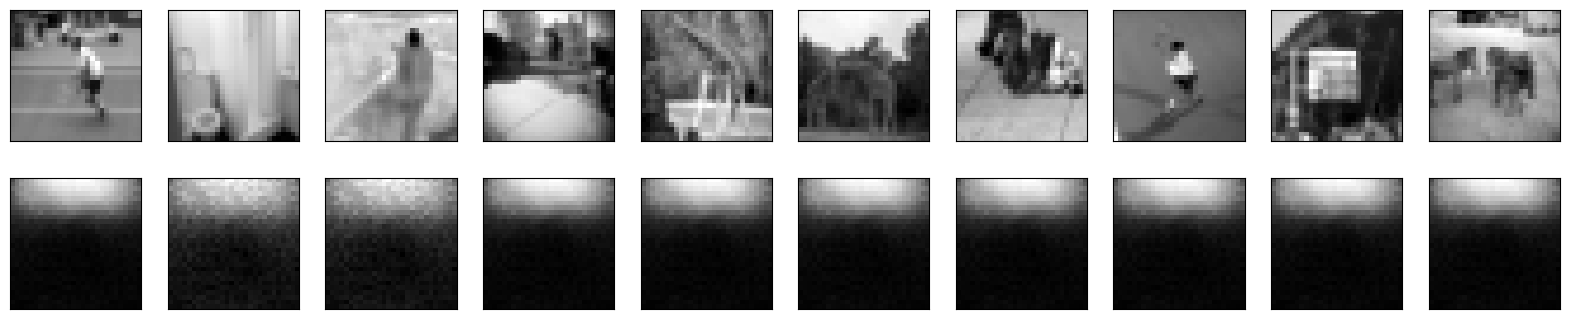

Visualizing reconstructions for Model4 (COCO):


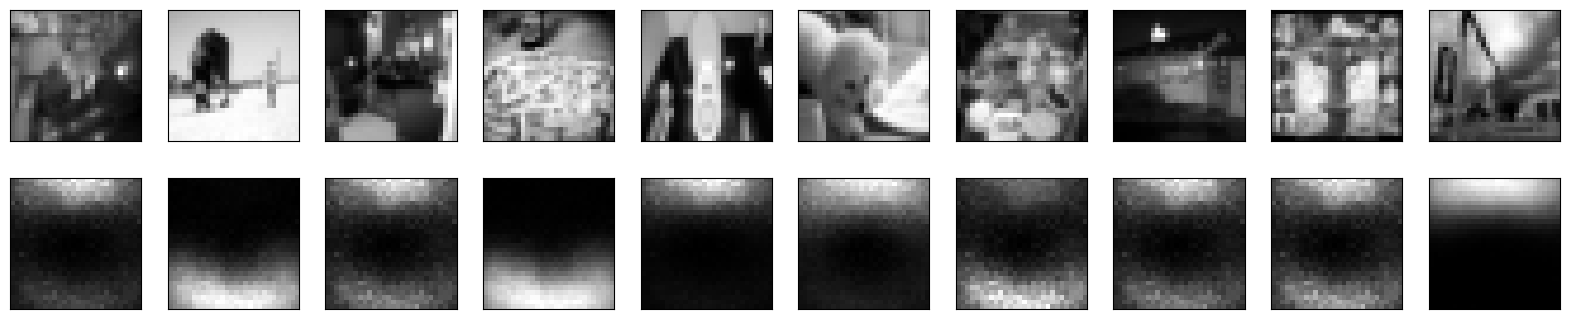

Visualizing reconstructions for Model5 (COCO):


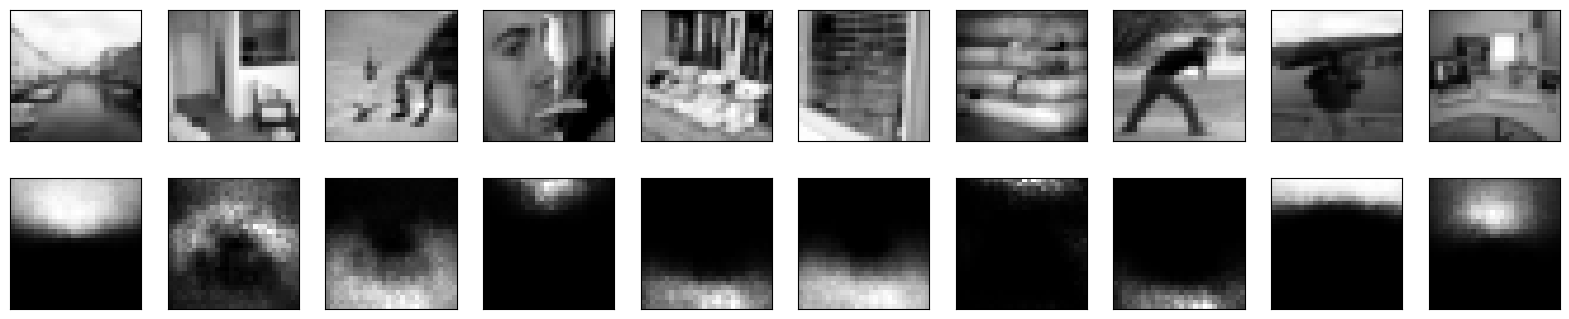

Visualizing reconstructions for Model6 (COCO):


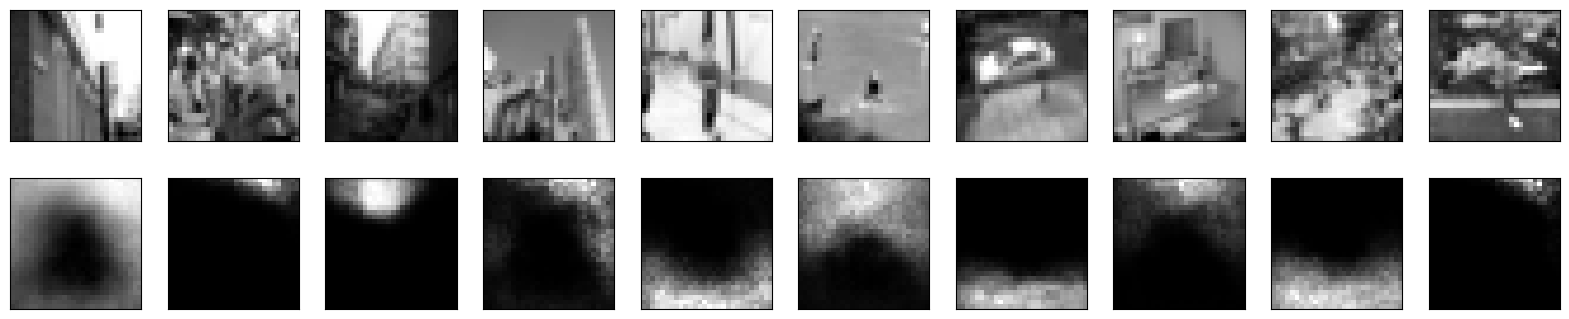

Model: Model1, Test Loss: 0.1973
Model: Model2, Test Loss: 0.1970
Model: Model3, Test Loss: 0.2257
Model: Model4, Test Loss: 0.2002
Model: Model5, Test Loss: 0.1947
Model: Model6, Test Loss: 0.1951


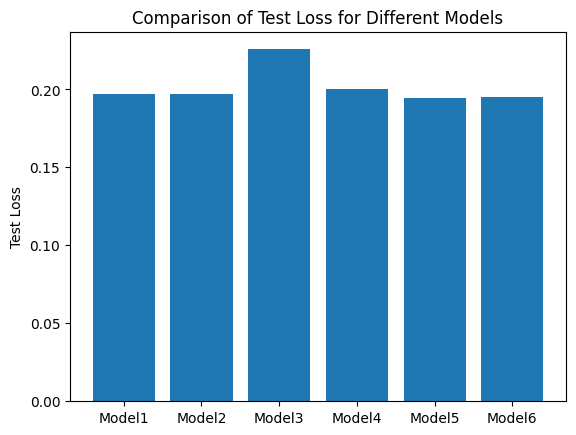

In [ ]:
# %%
import matplotlib.pyplot as plt

def visualize_reconstructions(model, test_loader, num_images=10):
    """Visualizes original and reconstructed images from the test set.

    Args:
        model (nn.Module): The trained autoencoder model.
        test_loader (DataLoader): DataLoader for the test set.
        num_images (int, optional): Number of images to visualize. Defaults to 10.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during inference
        for data in test_loader:
            inputs = data  # Get a batch of images from the test loader (custom collate function returns only images)
            inputs = inputs.view(-1, 784).to(device)  # Flatten the images and move to the device
            encoded, outputs = model(inputs)  # Get the encoded and decoded (reconstructed) outputs
            break  # Process only one batch for visualization

    # Reshape the tensors to image format for visualization
    inputs = inputs.view(-1, 28, 28)
    outputs = outputs.view(-1, 28, 28)

    # Plot the original and reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display the original image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(inputs[i].cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the reconstructed image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(outputs[i].cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()  # Show the plot


def compare_loss_functions(trained_models, test_loader):
    """Compares the loss functions of trained models on the test set.

    Args:
        trained_models (dict): A dictionary containing the trained models.
        test_loader (DataLoader): DataLoader for the test set.
    """
    loss_values = {}  # Dictionary to store the loss values for each model
    criterion = nn.MSELoss()  # Using Mean Squared Error (MSE) as the loss function

    for model_name, model in trained_models.items():
        model.eval()  # Set the model to evaluation mode
        total_loss = 0  # Initialize total loss for the current model
        with torch.no_grad():  # Disable gradient calculation during evaluation
            for data in test_loader:
                inputs = data  # Get a batch of images from the test loader (custom collate function returns only images)
                inputs = inputs.view(-1, 784).to(device)  # Flatten the images and move to the device
                encoded, outputs = model(inputs)  # Get the encoded and decoded (reconstructed) outputs
                loss = criterion(outputs, inputs)  # Calculate the reconstruction loss
                total_loss += loss.item()  # Accumulate the loss

        loss_values[model_name] = total_loss / len(test_loader)  # Calculate average loss for the model

    # Print the loss values for each model
    for model_name, loss_value in loss_values.items():
        print(f"Model: {model_name}, Test Loss: {loss_value:.4f}")

    # Plot the loss values for comparison
    plt.bar(loss_values.keys(), loss_values.values())
    plt.ylabel('Test Loss')
    plt.title('Comparison of Test Loss for Different Models')
    plt.show()  # Show the plot

In [ ]:
# %%
import torch
import torch.nn as nn

num_epochs = 10  # Define the number of training epochs

class MLP_COCO(nn.Module):
    """Multilayer Perceptron (MLP) autoencoder for COCO dataset images."""
    def __init__(self, encoder_layers, decoder_layers, activation, latent_dim):
        """Initializes the MLP_COCO model.

        Args:
            encoder_layers (list): List of layer sizes for the encoder.
            decoder_layers (list): List of layer sizes for the decoder.
            activation (nn.Module): Activation function to use.
            latent_dim (int): Dimensionality of the latent space.
        """
        super(MLP_COCO, self).__init__()

        # Encoder
        encoder_modules = []
        input_size = 784  # Input size for 28x28 grayscale images
        for layer_size in encoder_layers:
            encoder_modules.extend([
                nn.Linear(input_size, layer_size),
                activation(),
                nn.Dropout(0.2)  # Added dropout for regularization
            ])
            input_size = layer_size
        encoder_modules.append(nn.Linear(input_size, latent_dim))
        self.encoder = nn.Sequential(*encoder_modules)

        # Decoder
        decoder_modules = []
        input_size = latent_dim
        for layer_size in decoder_layers:
            decoder_modules.extend([
                nn.Linear(input_size, layer_size),
                activation(),
                nn.Dropout(0.2)  # Added dropout for regularization
            ])
            input_size = layer_size
        decoder_modules.append(nn.Linear(input_size, 784))  # Output size for 28x28 grayscale images
        # Consider using sigmoid for output if your images are normalized between 0 and 1
        # decoder_modules.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_modules)

    def forward(self, x):
        """Defines the forward pass of the MLP_COCO model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            tuple: A tuple containing the encoded and decoded tensors.
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def visualize_reconstructions_coco(model, coco_loader_resized, device, num_images=10):
    """Visualizes original and reconstructed images from the COCO dataset.

    Args:
        model (nn.Module): The trained autoencoder model.
        coco_loader_resized (DataLoader): DataLoader for the resized COCO dataset.
        device (torch.device): The device to run the model on (CPU or GPU).
        num_images (int, optional): Number of images to visualize. Defaults to 10.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during inference
        for batch in coco_loader_resized:  # Use the COCO data loader
            data = batch.to(device)
            data = data.view(data.size(0), -1)  # Flatten the images

            _, decoded = model(data)
            break  # Just visualize one batch

    # Reshape to images
    inputs = data.view(-1, 28, 28)
    outputs = decoded.view(-1, 28, 28)

    # Plot
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(inputs[i].cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstruction
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(outputs[i].cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Function to train and test the models with different configurations
def train_and_evaluate(configs, train_loader, test_loader, device):
    """Trains and evaluates MLP models with different configurations.

    Args:
        configs (list): A list of model configurations.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the test set.
        device (torch.device): The device to run the model on (CPU or GPU).
    """
    for config in configs:
        print(f"\nTraining {config['name']}...")

        # Initialize model, loss, and optimizer
        model = MLP_COCO(
            encoder_layers=config['encoder_layers'],
            decoder_layers=config['decoder_layers'],
            activation=config['activation'],
            latent_dim=config['latent_dim']
        ).to(device)

        # Consider adding weight decay to the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

        # Consider using a learning rate scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        criterion = nn.MSELoss()  # Example loss function

        # Training loop for COCO
        for epoch in range(num_epochs):
            for data in coco_loader_resized:  # Use the COCO data loader
                inputs = data.to(device)
                inputs = inputs.view(inputs.size(0), -1)  # Flatten the images

                optimizer.zero_grad()
                encoded, outputs = model(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()

            print(f'Model: {config["name"]}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluation (apply the same reshaping to the test data)
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                if isinstance(batch, list) or isinstance(batch, tuple):
                    images = batch[0]
                    data = images.to(device)
                else:
                    data = batch.to(device)
                # Reshape the input data to (batch_size, 784)
                data = data.view(data.size(0), -1)  # Flatten the images

                _, decoded = model(data)
                loss = criterion(decoded, data)
                total_loss += loss.item()

        avg_loss = total_loss / len(test_loader)
        print(f"{config['name']} - Test Loss: {avg_loss:.4f}")
        print(f"Visualizing reconstructions for {config['name']} on COCO:")
        visualize_reconstructions_coco(model, coco_loader_resized, device)


Training Model1...
Model: Model1, Epoch [1/10], Loss: 0.1535
Model: Model1, Epoch [2/10], Loss: 0.1330
Model: Model1, Epoch [3/10], Loss: 0.1422
Model: Model1, Epoch [4/10], Loss: 0.1366
Model: Model1, Epoch [5/10], Loss: 0.1281
Model: Model1, Epoch [6/10], Loss: 0.1343
Model: Model1, Epoch [7/10], Loss: 0.1385
Model: Model1, Epoch [8/10], Loss: 0.1334
Model: Model1, Epoch [9/10], Loss: 0.1199
Model: Model1, Epoch [10/10], Loss: 0.1327
Model1 - Test Loss: 0.1089
Visualizing reconstructions for Model1 on COCO:


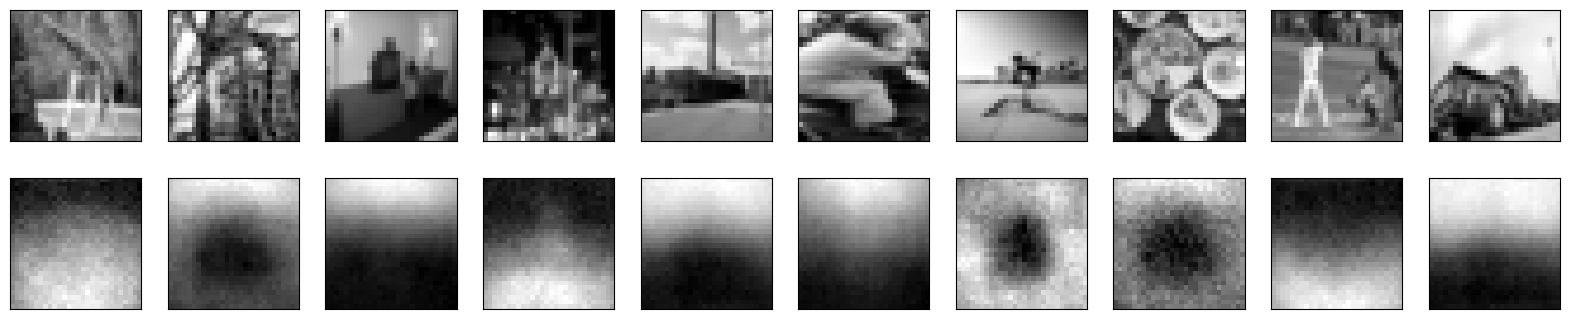


Training Model2...
Model: Model2, Epoch [1/10], Loss: 0.1643
Model: Model2, Epoch [2/10], Loss: 0.1280
Model: Model2, Epoch [3/10], Loss: 0.1271
Model: Model2, Epoch [4/10], Loss: 0.1313
Model: Model2, Epoch [5/10], Loss: 0.1331
Model: Model2, Epoch [6/10], Loss: 0.1275
Model: Model2, Epoch [7/10], Loss: 0.1297
Model: Model2, Epoch [8/10], Loss: 0.1350
Model: Model2, Epoch [9/10], Loss: 0.1348
Model: Model2, Epoch [10/10], Loss: 0.1237
Model2 - Test Loss: 0.1068
Visualizing reconstructions for Model2 on COCO:


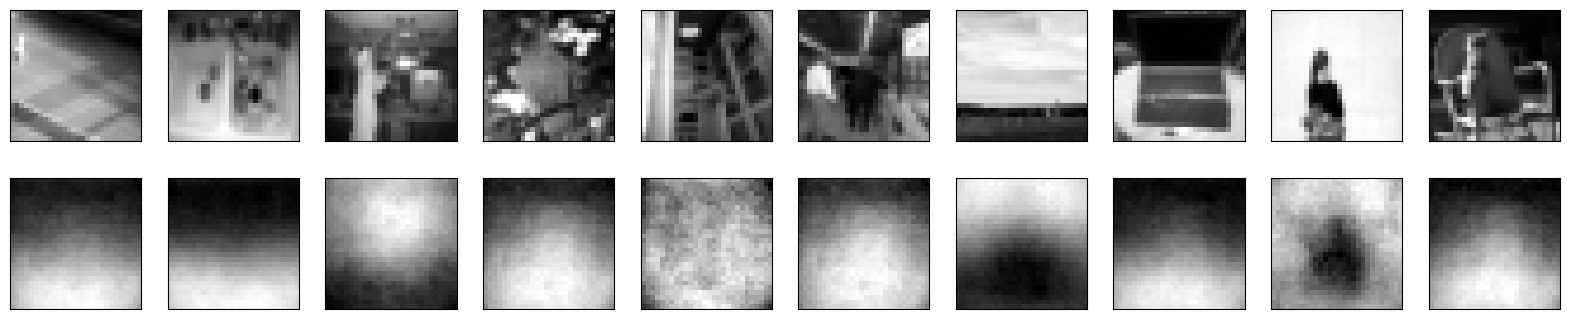


Training Model3...
Model: Model3, Epoch [1/10], Loss: 0.2501
Model: Model3, Epoch [2/10], Loss: 0.2111
Model: Model3, Epoch [3/10], Loss: 0.2049
Model: Model3, Epoch [4/10], Loss: 0.1930
Model: Model3, Epoch [5/10], Loss: 0.1731
Model: Model3, Epoch [6/10], Loss: 0.1730
Model: Model3, Epoch [7/10], Loss: 0.1605
Model: Model3, Epoch [8/10], Loss: 0.1695
Model: Model3, Epoch [9/10], Loss: 0.1612
Model: Model3, Epoch [10/10], Loss: 0.1689
Model3 - Test Loss: 0.1229
Visualizing reconstructions for Model3 on COCO:


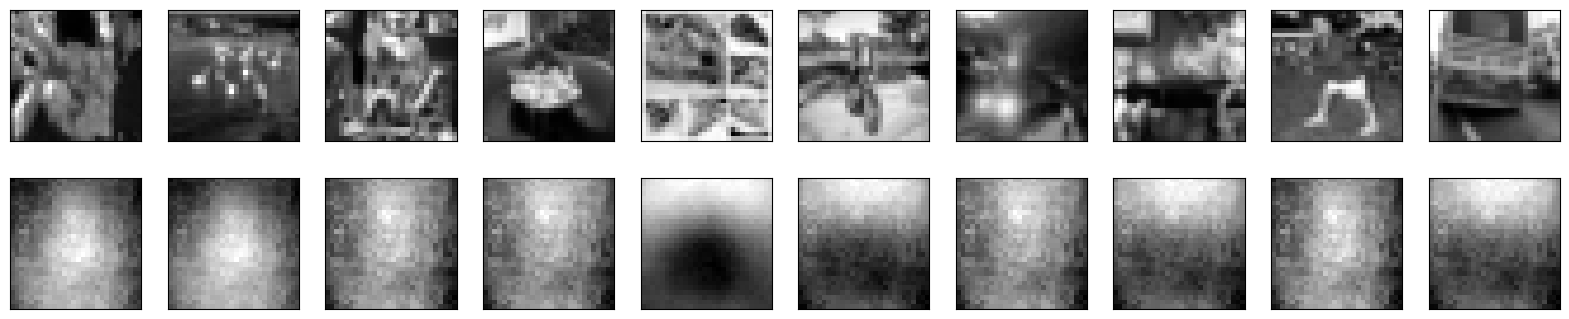


Training Model4...
Model: Model4, Epoch [1/10], Loss: 0.1206
Model: Model4, Epoch [2/10], Loss: 0.1036
Model: Model4, Epoch [3/10], Loss: 0.0842
Model: Model4, Epoch [4/10], Loss: 0.0846
Model: Model4, Epoch [5/10], Loss: 0.0802
Model: Model4, Epoch [6/10], Loss: 0.0873
Model: Model4, Epoch [7/10], Loss: 0.0779
Model: Model4, Epoch [8/10], Loss: 0.0854
Model: Model4, Epoch [9/10], Loss: 0.0856
Model: Model4, Epoch [10/10], Loss: 0.0817
Model4 - Test Loss: 0.0630
Visualizing reconstructions for Model4 on COCO:


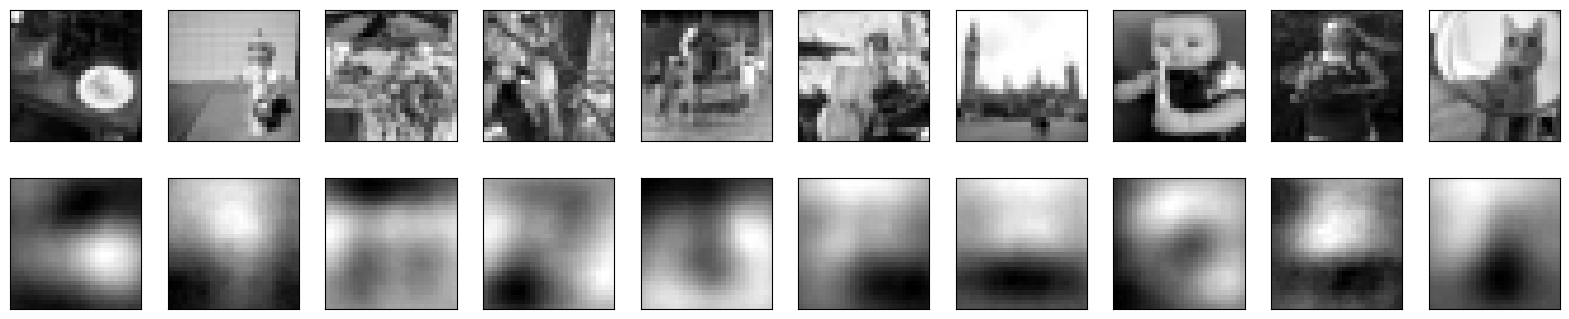


Training Model5...
Model: Model5, Epoch [1/10], Loss: 0.1664
Model: Model5, Epoch [2/10], Loss: 0.1625
Model: Model5, Epoch [3/10], Loss: 0.1328
Model: Model5, Epoch [4/10], Loss: 0.1265
Model: Model5, Epoch [5/10], Loss: 0.1318
Model: Model5, Epoch [6/10], Loss: 0.1220
Model: Model5, Epoch [7/10], Loss: 0.1172
Model: Model5, Epoch [8/10], Loss: 0.1345
Model: Model5, Epoch [9/10], Loss: 0.1294
Model: Model5, Epoch [10/10], Loss: 0.1130
Model5 - Test Loss: 0.0886
Visualizing reconstructions for Model5 on COCO:


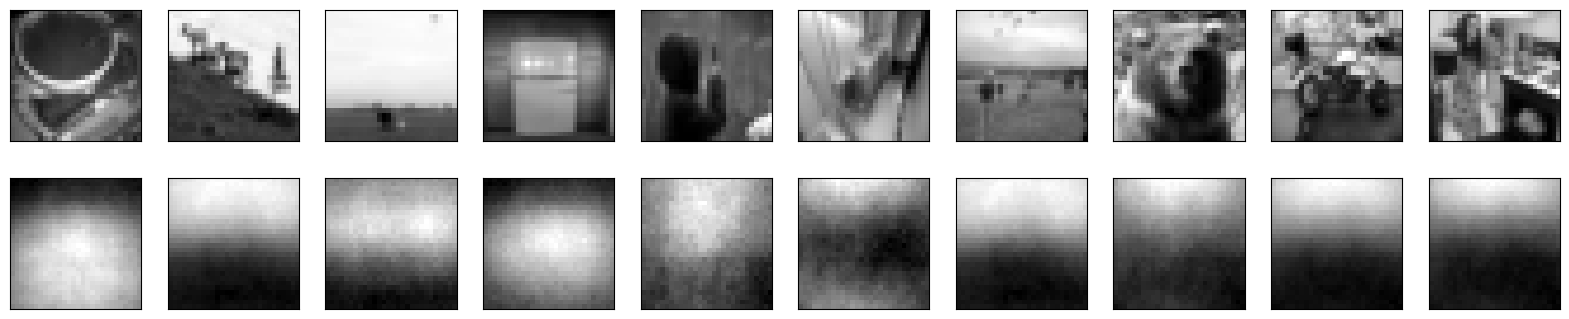


Training Model6...
Model: Model6, Epoch [1/10], Loss: 0.1895
Model: Model6, Epoch [2/10], Loss: 0.1733
Model: Model6, Epoch [3/10], Loss: 0.1462
Model: Model6, Epoch [4/10], Loss: 0.1376
Model: Model6, Epoch [5/10], Loss: 0.1241
Model: Model6, Epoch [6/10], Loss: 0.1308
Model: Model6, Epoch [7/10], Loss: 0.1371
Model: Model6, Epoch [8/10], Loss: 0.1236
Model: Model6, Epoch [9/10], Loss: 0.1259
Model: Model6, Epoch [10/10], Loss: 0.1309
Model6 - Test Loss: 0.1069
Visualizing reconstructions for Model6 on COCO:


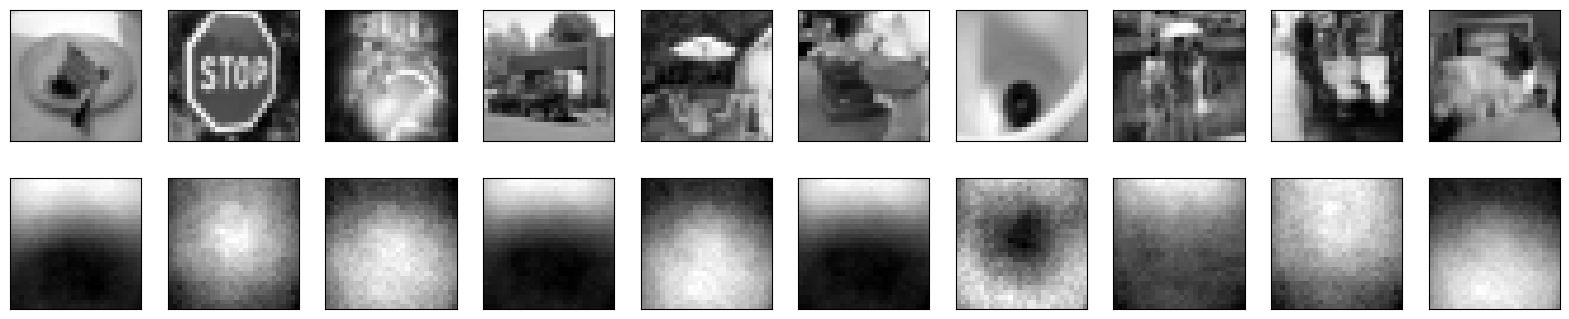

In [ ]:
train_and_evaluate(configs, train_loader, test_loader, device)